In [ ]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

MODEL_NAME = "Rostlab/prot_bert" 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # using mps instead of cuda for training on mac
#DEVICE = "cpu"  # use GPU if available, otherwise CPU
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-5

Using device: mps


In [37]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [38]:
df = df_raw[~df_raw["label"].str.contains("P")]
df.describe()

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [39]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
label_seqs = df_encoded["label"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,1,20423,19036,41,16382


In [40]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [41]:
# Stratify by sequence length to avoid ValueError
train_seqs, test_seqs, train_label_seqs, test_label_seqs = train_test_split(
    sequences, label_seqs, test_size=0.3, random_state=42
)

In [42]:
# Load the data 
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # preprocess the sequence (insert spaces between amino acids)
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]
        # Tokenize the sequence (padding to ensure all sequences are the same length -> 512 tokens) 
        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Build a label tensor of the same length as input_ids.
        # For tokens beyond the original sequence length, assign -100 so that loss func ignores them.
        orig_length = len(seq)
        token_labels = []
        
        for i in range(input_ids.size(0)):
            if i == 0 or i > orig_length:  
                token_labels.append(-100)  # ignore padding tokens
            else:
                # Use the already encoded label directly
                token_labels.append(labels[i-1])
        labels_tensor = torch.tensor(token_labels)
        
        return {
            'input_ids': input_ids, # tokenized and padded 
            'attention_mask': attention_mask, # differentiate between padding and non-padding tokens
            'labels': labels_tensor # aligned label tensor
        }

train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model):
        super().__init__()
        self.encoder = encoder_model  # encoder: ProtBERT model
        self.dropout = nn.Dropout(0.2)
        hidden_size = self.encoder.config.hidden_size
        # First convolution: map features to 1024 channels
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=6, dilation=2, padding=5)
        # Second convolution: map features to the 6 classes for each token
        self.conv2 = nn.Conv1d(in_channels=1024, out_channels=NUM_CLASSES, kernel_size=3, dilation=2, padding=2)
        # Linear classifier applied on the conv1 output for token-level classification
        self.classifier = nn.Linear(1024, NUM_CLASSES)
        

    def forward(self, input_ids, attention_mask):
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        
        # Transpose to (batch, hidden_size, seq_len) for 1D conv
        x = hidden_states.transpose(1, 2)
        
        # First convolution and activation
        x_conv1 = F.relu(self.conv1(x))  # shape: (batch, 1024, seq_len)
        
        # Convolutional head
        x_conv2 = self.conv2(x_conv1)  # shape: (batch, NUM_CLASSES, seq_len)
        x_conv2 = x_conv2.transpose(1, 2)  # shape: (batch, seq_len, NUM_CLASSES)
        
        # Linear head: apply classifier on each token representation from conv1 output
        x_linear = self.classifier(x_conv1.transpose(1, 2))  # shape: (batch, seq_len, NUM_CLASSES)
        
        # Addition of both classifier outputs
        x_out = self.dropout(x_conv2 + x_linear)  # shape: (batch, seq_len, NUM_CLASSES)
        return x_out

In [44]:
from transformers import get_linear_schedule_with_warmup

# Initialize the model
model = SPCNNClassifier(encoder).to(DEVICE)

# optimizer and Loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,           # Learning rate
    betas=(0.85, 0.999),  # momentum, can overshoot 
    eps=1e-6,          # epsilon
    weight_decay=0.01  # regularization to prevent overfitting
)

# scheduler for learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * EPOCHS
)

# Counter({'I': 1204001, 'O': 362643, 'S': 85526, 'M': 74445, 'L': 46065, 'T': 22272, 'P': 951})
class_counts = [1204001, 85526, 22272, 46865, 74445, 362643]  # Count for each class (I, S, T, L, M, O)
# hopefully deals with the class imbalance
weights = torch.tensor([1.0 / count for count in class_counts], device=DEVICE)

# loss function that ignores the padding tokens (-100)
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

In [45]:
# Compute sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # Step 1: Reconstruct sequence-wise predictions and labels
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # Step 2: Compute sequence-level accuracy using is_valid variable
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [46]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef

def evaluate_model(model, data_loader, loss_fn, test_label_seqs):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in tqdm(data_loader, desc="Evaluation", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), labels.reshape(-1))
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        # Flatten and filter out padding tokens (-100)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        valid_idx = labels_flat != -100
        all_preds.extend(preds_flat[valid_idx].cpu().numpy())
        all_labels.extend(labels_flat[valid_idx].cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
    
    try:
        mcc = matthews_corrcoef(all_labels, all_preds)
    except ImportError:
        mcc = None

    print("Classification Report:")
    print(report)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Token-level Accuracy: {acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc if mcc is not None else 'N/A'}")
    
    # Compute sequence-level accuracy if the function is defined
    try:
        seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
        print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")
    except Exception as e:
        seq_acc_val = None
        print("Sequence Level Accuracy could not be computed:", e)
    
    return avg_loss, acc, mcc, seq_acc_val


In [47]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm

writer = SummaryWriter(log_dir="/Users/jonas/Desktop/Uni/PBL/logs/prot_bert_linear_classifier_v2")

for param in model.encoder.parameters():
    param.requires_grad = False

for epoch in range(EPOCHS):

    model.train()

    # Gradually unfreeze only a subset of encoder layers for efficiency
    if epoch == 4:
        # Unfreeze only the last encoder layer
        for param in model.encoder.encoder.layer[-1].parameters():
            param.requires_grad = True
    elif epoch == 7:
        # Optionally unfreeze one more layer rather than the full encoder
        for param in model.encoder.encoder.layer[-2].parameters():
            param.requires_grad = True

    # progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    total_loss = 0 # total epoch loss

    for batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        token_labels = batch['labels'].to(DEVICE)

        optimizer.zero_grad()  # resets gradients
        logits = model(input_ids, attention_mask)  # forward pass
        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), token_labels.reshape(-1)) # flatten logits and labels and compute loss
        loss.backward()  # backpropagation
        optimizer.step()  # update weights with optimizer
        scheduler.step() # update learning rate

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    """
    eval_loss, eval_acc, eval_mcc, seq_acc_val = evaluate_model(model, test_loader, loss_fn, test_label_seqs)
    writer.add_scalar("Loss/eval", eval_loss, epoch)
    writer.add_scalar("Accuracy/eval", eval_acc, epoch)
    writer.add_scalar("MCC/eval", eval_mcc, epoch)
    writer.add_scalar("Sequence_Accuracy/eval", seq_acc_val, epoch)
    print(f"Epoch {epoch+1}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_acc:.4f}, Eval MCC: {eval_mcc:.4f}, Sequence Level Accuracy: {seq_acc_val:.4f}")
    """
    



Epoch 1/4: 100%|██████████| 309/309 [36:17<00:00,  7.05s/batch, loss=0.178]


Epoch 1, Loss: 0.3182


Epoch 2/4: 100%|██████████| 309/309 [36:04<00:00,  7.00s/batch, loss=0.183]


Epoch 2, Loss: 0.2007


Epoch 3/4: 100%|██████████| 309/309 [36:00<00:00,  6.99s/batch, loss=0.173]


Epoch 3, Loss: 0.1905


Epoch 4/4: 100%|██████████| 309/309 [36:01<00:00,  7.00s/batch, loss=0.235]

Epoch 4, Loss: 0.1830


Classification Report:
              precision    recall  f1-score   support

           S       0.98      0.70      0.81     25619
           T       0.90      0.95      0.93      6739
           L       0.75      0.98      0.85     14328
           I       0.94      0.99      0.97    358968
           M       0.81      0.87      0.84     21858
           O       0.98      0.81      0.88    108891

    accuracy                           0.93    536403
   macro avg       0.89      0.88      0.88    536403
weighted avg       0.94      0.93      0.93    536403



Classification Report:
              precision    recall  f1-score   support

           S       0.98      0.70      0.81     25619
           T       0.90      0.95      0.93      6739
           L       0.75      0.98      0.85     14328
           I       0.94      0.99      0.97    358968
           M       0.81      0.87      0.84     21858
           O       0.98      0.81      0.88    108891

    accuracy                           0.93    536403
   macro avg       0.89      0.88      0.88    536403
weighted avg       0.94      0.93      0.93    536403

Average Loss: 0.0657
Token-level Accuracy: 0.9343
Matthews Correlation Coefficient (MCC): 0.868810933889746
Sequence Level Accuracy: 0.7686
Epoch 4, Eval Loss: 0.0657, Eval Accuracy: 0.9343, Eval MCC: 0.8688, Sequence Level Accuracy: 0.7686
Matthews Correlation Coefficient (MCC): 0.8688


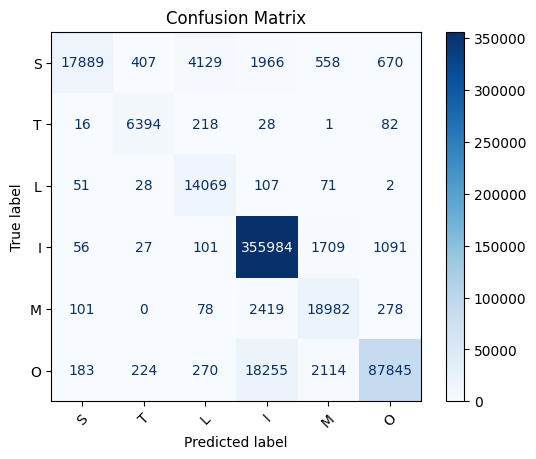

Epoch 4, Val Loss: 0.0657, Val Acc: 0.9343


In [ ]:
# Evaluation

import matplotlib.pyplot as plt

model.eval()
val_loss = 0
all_preds = [] # predicted labels
all_labels = [] # true types
with torch.no_grad():
    # uses the batches from the test set for eval
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids, attention_mask) # runs forward pass
        preds = torch.argmax(logits, dim=-1) # get per token predicted labels

        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), labels.reshape(-1)) # calculate loss
        val_loss += loss.item()

        # flatten the predictions and labels
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        valid_idx = labels_flat != -100 # exclude padding tokens (-100)
        all_preds.extend(preds_flat[valid_idx].cpu().numpy())
        all_labels.extend(labels_flat[valid_idx].cpu().numpy())

# Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

# Evaluate the model
eval_loss, eval_acc, eval_mcc, seq_acc_val = evaluate_model(model, test_loader, loss_fn, test_label_seqs)
writer.add_scalar("Loss/eval", eval_loss, epoch)
writer.add_scalar("Accuracy/eval", eval_acc, epoch)
writer.add_scalar("MCC/eval", eval_mcc, epoch)
writer.add_scalar("Sequence_Accuracy/eval", seq_acc_val, epoch)
print(f"Epoch {epoch+1}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_acc:.4f}, Eval MCC: {eval_mcc:.4f}, Sequence Level Accuracy: {seq_acc_val:.4f}")

from sklearn.metrics import matthews_corrcoef

# MCC
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# For TensorBoard
avg_val_loss = val_loss / len(test_loader)
val_acc = accuracy_score(all_labels, all_preds)
writer.add_scalar("Loss/val", avg_val_loss, epoch)
writer.add_scalar("Accuracy/val", val_acc, epoch)

writer.flush()
writer.close()


In [50]:

torch.save(model.state_dict(), "/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v2.pt")